# Applying Different regressions of Customer Churn Telco Data
## Author: Hristo Panov

## 00 Prerequisite and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Custom Imports
import sys
sys.path.insert(0, '..')

from utils.const_folders import folder_paths
from utils.function_freqs import freqs

%matplotlib inline

## 01 Read Data

In [53]:
# Read From CSV
df = pd.read_csv(
    f"{folder_paths.path}/data_cleaned.csv"
    ,sep=","
    ,index_col=None
)

## 02 Basic Checks

In [54]:
# Columns and Rows
print('The dataset contains {one} rows and {two} columns'.format(one=df.shape[0],two=df.shape[1]))
print('Those columns are {one}'.format(one=df.columns.to_list()))

The dataset contains 7043 rows and 21 columns
Those columns are ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [55]:
# Preview
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6922,9398-MMQTO,Male,No,No,No,3,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,No,Credit card (automatic),74.45,221.10,No
1645,9490-DFPMD,Female,Yes,No,No,42,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.65,3541.35,Yes
90,4767-HZZHQ,Male,No,Yes,Yes,30,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,No,Bank transfer (automatic),82.05,2570.20,No
873,5073-WXOYN,Female,No,No,No,60,No,No phone service,DSL,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,50.80,3027.40,Yes
3833,9169-BSVIN,Male,No,No,No,12,Yes,Yes,DSL,No,...,Yes,No,Yes,Yes,Month-to-month,No,Bank transfer (automatic),74.75,827.05,No


In [56]:
#Check if the dataframe is unique on Customer Level - aka each row cointains information about one customer
df.shape[0] == len(df['customerID'].unique())

True

In [57]:
#Set the index of the data set to be equal to the customerID
df.set_index('customerID',inplace=True)

In [58]:
#Explore Feature types
df.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## 03 Data Preprocessing

In [59]:
df_for_models = df.copy()
df_for_models.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.000,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.85,118.75
TotalCharges,7043.0,2281.916928,2265.270398,18.80,402.225,1397.475,3786.60,8684.80


In [60]:
def convert_to_0_1(dataset,variable,value_if_true):
    dataset[variable] = [1 if x == value_if_true else 0 for x in dataset[variable]]

In [61]:
for feature in ['Partner','Dependents','PhoneService','PaperlessBilling','Churn','SeniorCitizen']:
    convert_to_0_1(df_for_models,feature,'Yes')

In [64]:
convert_to_0_1(df_for_models,'gender','Female')

In [65]:
df_for_models.sample(5).head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
3488-PGMQJ,0,1,0,0,8,1,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,74.50,606.55,1
6647-ZEDXT,1,0,0,0,30,1,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,0,Credit card (automatic),110.45,3327.05,0
1493-AMTIE,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,1,Bank transfer (automatic),20.20,20.20,1
4283-IVYCI,0,0,0,0,9,1,No,DSL,Yes,No,No,Yes,No,Yes,Month-to-month,0,Mailed check,64.95,547.80,0
0265-PSUAE,1,0,1,1,16,1,No,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,0,Bank transfer (automatic),100.70,1522.70,0


In [67]:
df_for_models = pd.get_dummies(df_for_models, columns = df_for_models.select_dtypes(include='object').columns)

In [68]:
df_for_models.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMetho

In [69]:
telco_data_features = df_for_models.drop(["Churn"], axis = 1)
telco_data_target = df_for_models.Churn

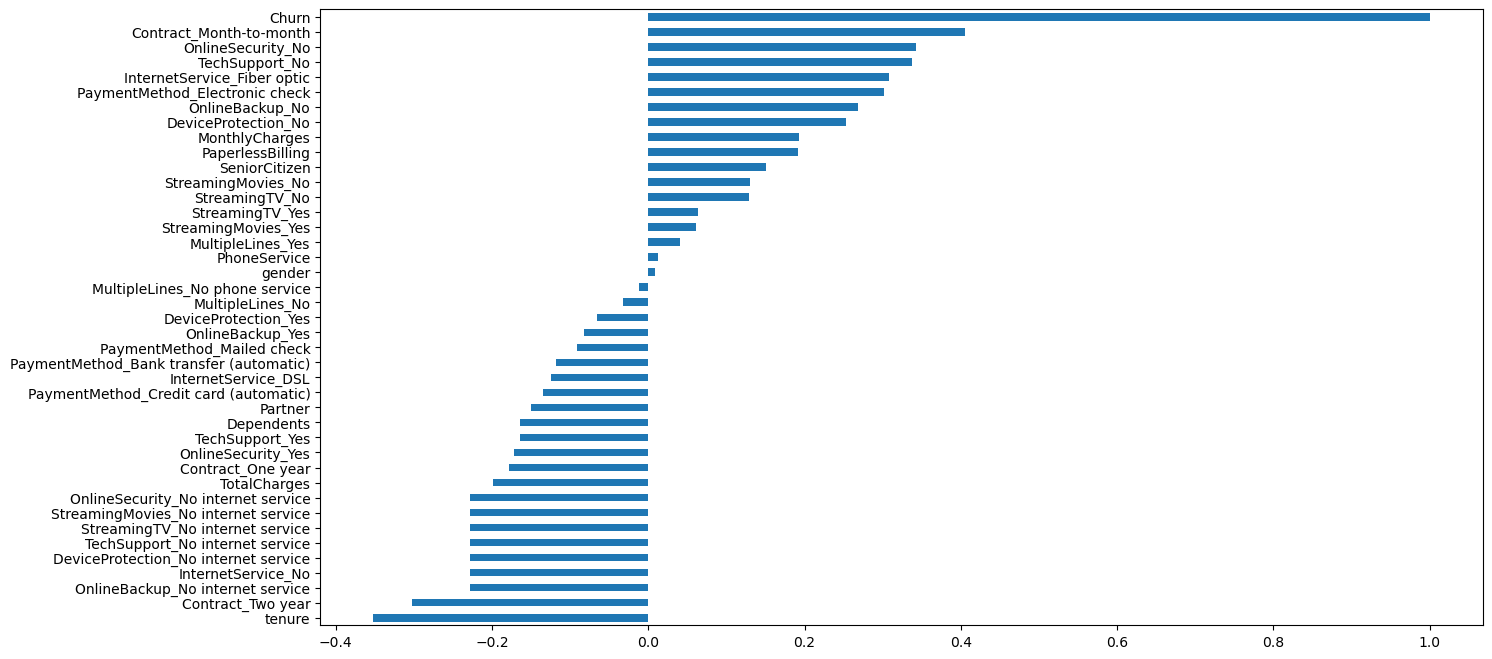

In [73]:
## Plot Correlation
plt.figure(figsize=(15,8))
df_for_models.corr()['Churn'].sort_values(ascending = True).plot(kind='barh')
plt.show()

## 04 Train Test Split

In [77]:
scaler = MinMaxScaler()

telco_data_features_scaled = scaler.fit_transform(telco_data_features)

In [78]:
features_train, features_test, target_train, target_test = train_test_split(
    telco_data_features_scaled, telco_data_target, train_size = 0.7, test_size = 0.3, random_state = 42)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape, sep = "\r\n")

(4930, 40)
(2113, 40)
(4930,)
(2113,)


## 05.1 Logistic Regression sklearn

In [79]:
model = LogisticRegression()
model.fit(features_train, target_train)

LogisticRegression()

In [80]:
print('coefficient : {one} \n\n Intercet : {two}'.format(one = model.coef_, two = model.intercept_))

coefficient : [[ 7.58333909e-02  2.01756972e-01  7.77025708e-04 -1.19656376e-01
  -2.92501140e+00 -1.29735999e-01  3.03963955e-01 -2.48481155e-01
   1.10028940e+00 -1.92287019e-01  1.30543918e-01  6.25510195e-02
  -3.66091308e-01  4.70822323e-01 -1.03923097e-01  2.66520696e-01
  -1.03923097e-01 -1.61789681e-01  1.41731551e-01 -1.03923097e-01
  -3.70005354e-02  4.32433187e-02 -1.03923097e-01  6.14876966e-02
   1.93165608e-01 -1.03923097e-01 -8.84345923e-02 -7.40769553e-03
  -1.03923097e-01  1.12138711e-01 -1.17637115e-01 -1.03923097e-01
   2.22368130e-01  7.19482194e-01  7.99773022e-02 -7.98651578e-01
  -6.34033687e-02 -1.33681948e-01  2.72666762e-01 -7.47735263e-02]] 

 Intercet : [-1.06227412]


In [81]:
score = model.score(features_test, target_test)
print(score)

0.812588736393753


In [82]:
weights = pd.Series(model.coef_[0],
                 index=telco_data_features.columns.values)
weights

gender                                     0.075833
SeniorCitizen                              0.201757
Partner                                    0.000777
Dependents                                -0.119656
tenure                                    -2.925011
PhoneService                              -0.129736
PaperlessBilling                           0.303964
MonthlyCharges                            -0.248481
TotalCharges                               1.100289
MultipleLines_No                          -0.192287
MultipleLines_No phone service             0.130544
MultipleLines_Yes                          0.062551
InternetService_DSL                       -0.366091
InternetService_Fiber optic                0.470822
InternetService_No                        -0.103923
OnlineSecurity_No                          0.266521
OnlineSecurity_No internet service        -0.103923
OnlineSecurity_Yes                        -0.161790
OnlineBackup_No                            0.141732
OnlineBackup

In [83]:
conf_matrix = round(pd.DataFrame(metrics.confusion_matrix(target_test, model.predict(features_test))/len(target_test))*100,4)
conf_matrix

,0,1
0,65.7832,7.0516
1,11.6895,15.4756


## 05.2 Logistic Regression Statsmodel

In [84]:
logit_model=sm.Logit(target_train,features_train)
model=logit_model.fit()
print(model.summary())

         Current function value: 0.417623
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4906
Method:                           MLE   Df Model:                           23
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.2748
Time:                        16:37:24   Log-Likelihood:                -2058.9
converged:                      False   LL-Null:                       -2838.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0714   1.33e+06   5.36e-08      1.000   -2.61e+06    2.61e+06
x2             0.2057    1.5e+06   1.37e-07      1.000   -2.93e+0

c:\Users\hpano\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [85]:
model_predict=np.where(model.predict(features_test)<0.5,0,1)
model_predict.mean()

0.22716516800757217

In [86]:
cm = round(pd.DataFrame(metrics.confusion_matrix(target_test, model_predict)/len(target_test))*100,4)
cm

,0,1
0,65.6413,7.1936
1,11.6422,15.5230


In [87]:
def accuracy(pred_table):
    """
    Precision given pred_table. Binary classification only. Assumes group 0
    is the True.
    """
    tp, fp, fn, tn = map(float, pred_table.flatten())
    return (tp + tn) / (tp + tn + fp + fn)

In [88]:
accuracy(metrics.confusion_matrix(target_test, model_predict))

0.8116422148603881

### 05.3 Linear Regression sklearn

In [90]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [91]:
print('coefficient : {one} \n\n Intercet : {two}'.format(one = model.coef_, two = model.intercept_))

coefficient : [ 1.32920125e-02  4.52836084e-02 -3.51699772e-04 -1.56017263e-02
 -1.25456981e-01 -1.67845273e+12  4.27308015e-02 -4.95860673e-01
 -3.78429725e-01 -2.70705625e+10 -1.70552330e+12 -2.70705625e+10
 -1.56927895e+12 -1.56927895e+12 -2.12181353e+11 -4.32978122e+11
 -7.73386232e+11 -4.32978122e+11  2.81175432e+11 -3.69720321e+11
  2.81175432e+11  9.54745479e+10 -1.61760578e+11  9.54745479e+10
 -2.85471522e+11 -2.76800794e+11 -2.85471522e+11 -6.27549837e+11
 -2.76800794e+11 -6.27549837e+11  1.91177583e+11 -2.76800794e+11
  1.91177583e+11 -6.31175807e+10 -6.31175807e+10 -6.31175807e+10
 -5.11095202e+10 -5.11095202e+10 -5.11095202e+10 -5.11095202e+10] 

 Intercet : 4167201263497.8506


In [92]:
score = model.score(features_test, target_test)
print(score)

0.30653891325522153


In [93]:
weights = pd.Series(model.coef_[0],
                 index=telco_data_features.columns.values)
weights

gender                                     0.013292
SeniorCitizen                              0.013292
Partner                                    0.013292
Dependents                                 0.013292
tenure                                     0.013292
PhoneService                               0.013292
PaperlessBilling                           0.013292
MonthlyCharges                             0.013292
TotalCharges                               0.013292
MultipleLines_No                           0.013292
MultipleLines_No phone service             0.013292
MultipleLines_Yes                          0.013292
InternetService_DSL                        0.013292
InternetService_Fiber optic                0.013292
InternetService_No                         0.013292
OnlineSecurity_No                          0.013292
OnlineSecurity_No internet service         0.013292
OnlineSecurity_Yes                         0.013292
OnlineBackup_No                            0.013292
OnlineBackup